In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.base import clone

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline

In [2]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    """
    Computes meta-features using the classifier.
    
    :arg clf: scikit-learn classifier
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    X_meta_train = np.zeros_like(y_train, dtype=np.float32)
    for train_fold_index, predict_fold_index in cv.split(X_train):
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        X_meta_train[predict_fold_index] = folded_clf.predict_proba(X_fold_predict)[:, 1]
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict_proba(X_test)[:, 1]
    
    return X_meta_train, X_meta_test

In [3]:
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
    """
    Generates metafeatures using a list of classifiers.
    
    :arg classifiers: list of scikit-learn classifiers
    :args X_train, y_train: training set
    :arg X_test: testing set
    :arg cv: cross-validation folding
    """
    features = [
        compute_meta_feature(clf, X_train, X_test, y_train, cv)
        for clf in tqdm(classifiers)
    ]
    
    stacked_features_train = np.vstack([
        features_train for features_train, features_test in features
    ]).T

    stacked_features_test = np.vstack([
        features_test for features_train, features_test in features
    ]).T
    
    return stacked_features_train, stacked_features_test

In [4]:
# Импортируем данные из соревнования, сохраняя путь к файлам в переменной DATA_DIR
DATA_DIR = 'data/'
train = pd.read_csv(DATA_DIR + 'default_train.csv')
train.head()

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


<AxesSubplot:>

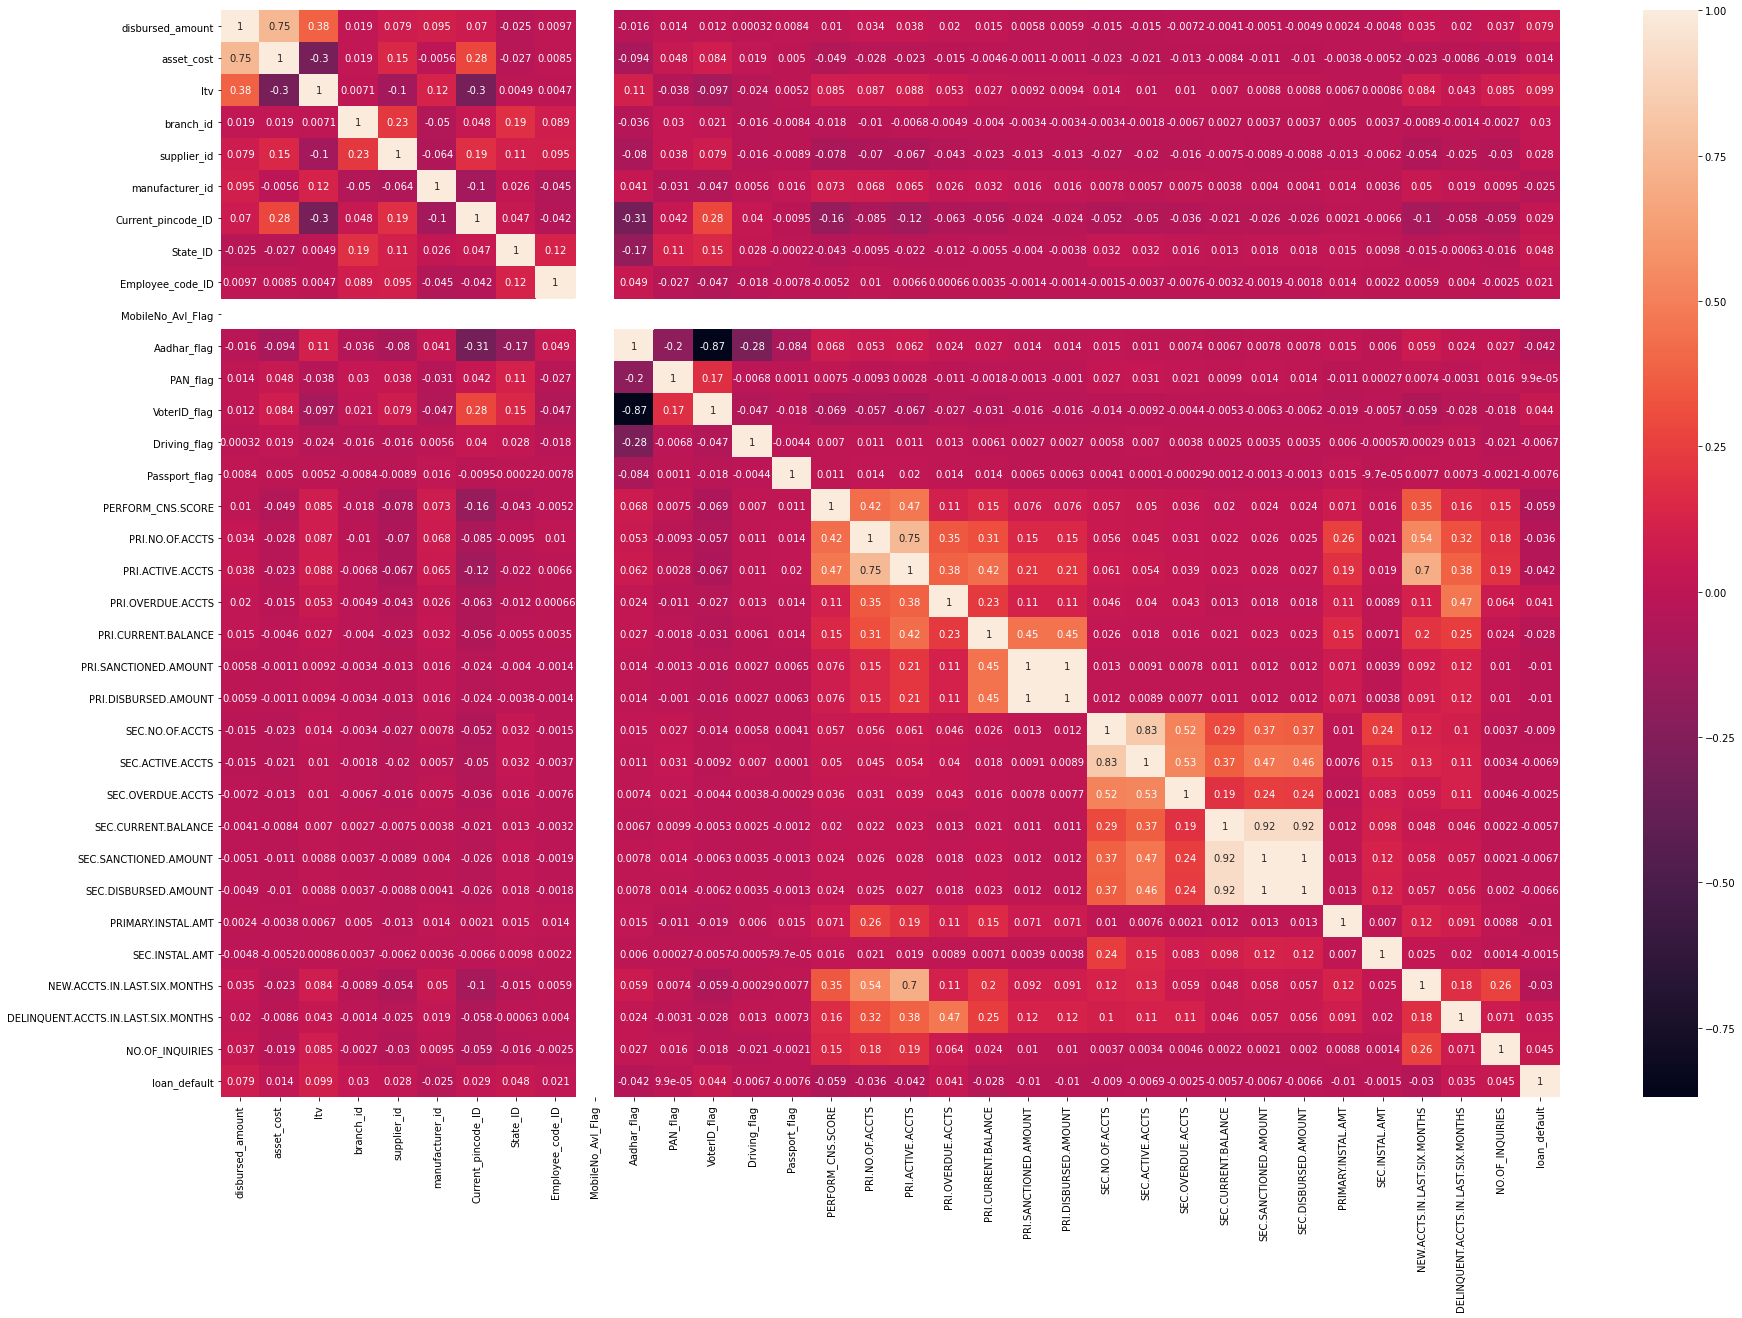

In [5]:
corr = train.corr()
plt.figure(figsize=(30, 20))

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True)

In [6]:
train.columns

Index(['disbursed_amount', 'asset_cost', 'ltv', 'branch_id', 'supplier_id',
       'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default'],
      dtype='object')

In [7]:
train['MobileNo_Avl_Flag'].value_counts()
train = train.drop(['MobileNo_Avl_Flag'], axis=1)

Похоже, что признак MobileNo_Avl_Flag лишний, уберем его

<AxesSubplot:>

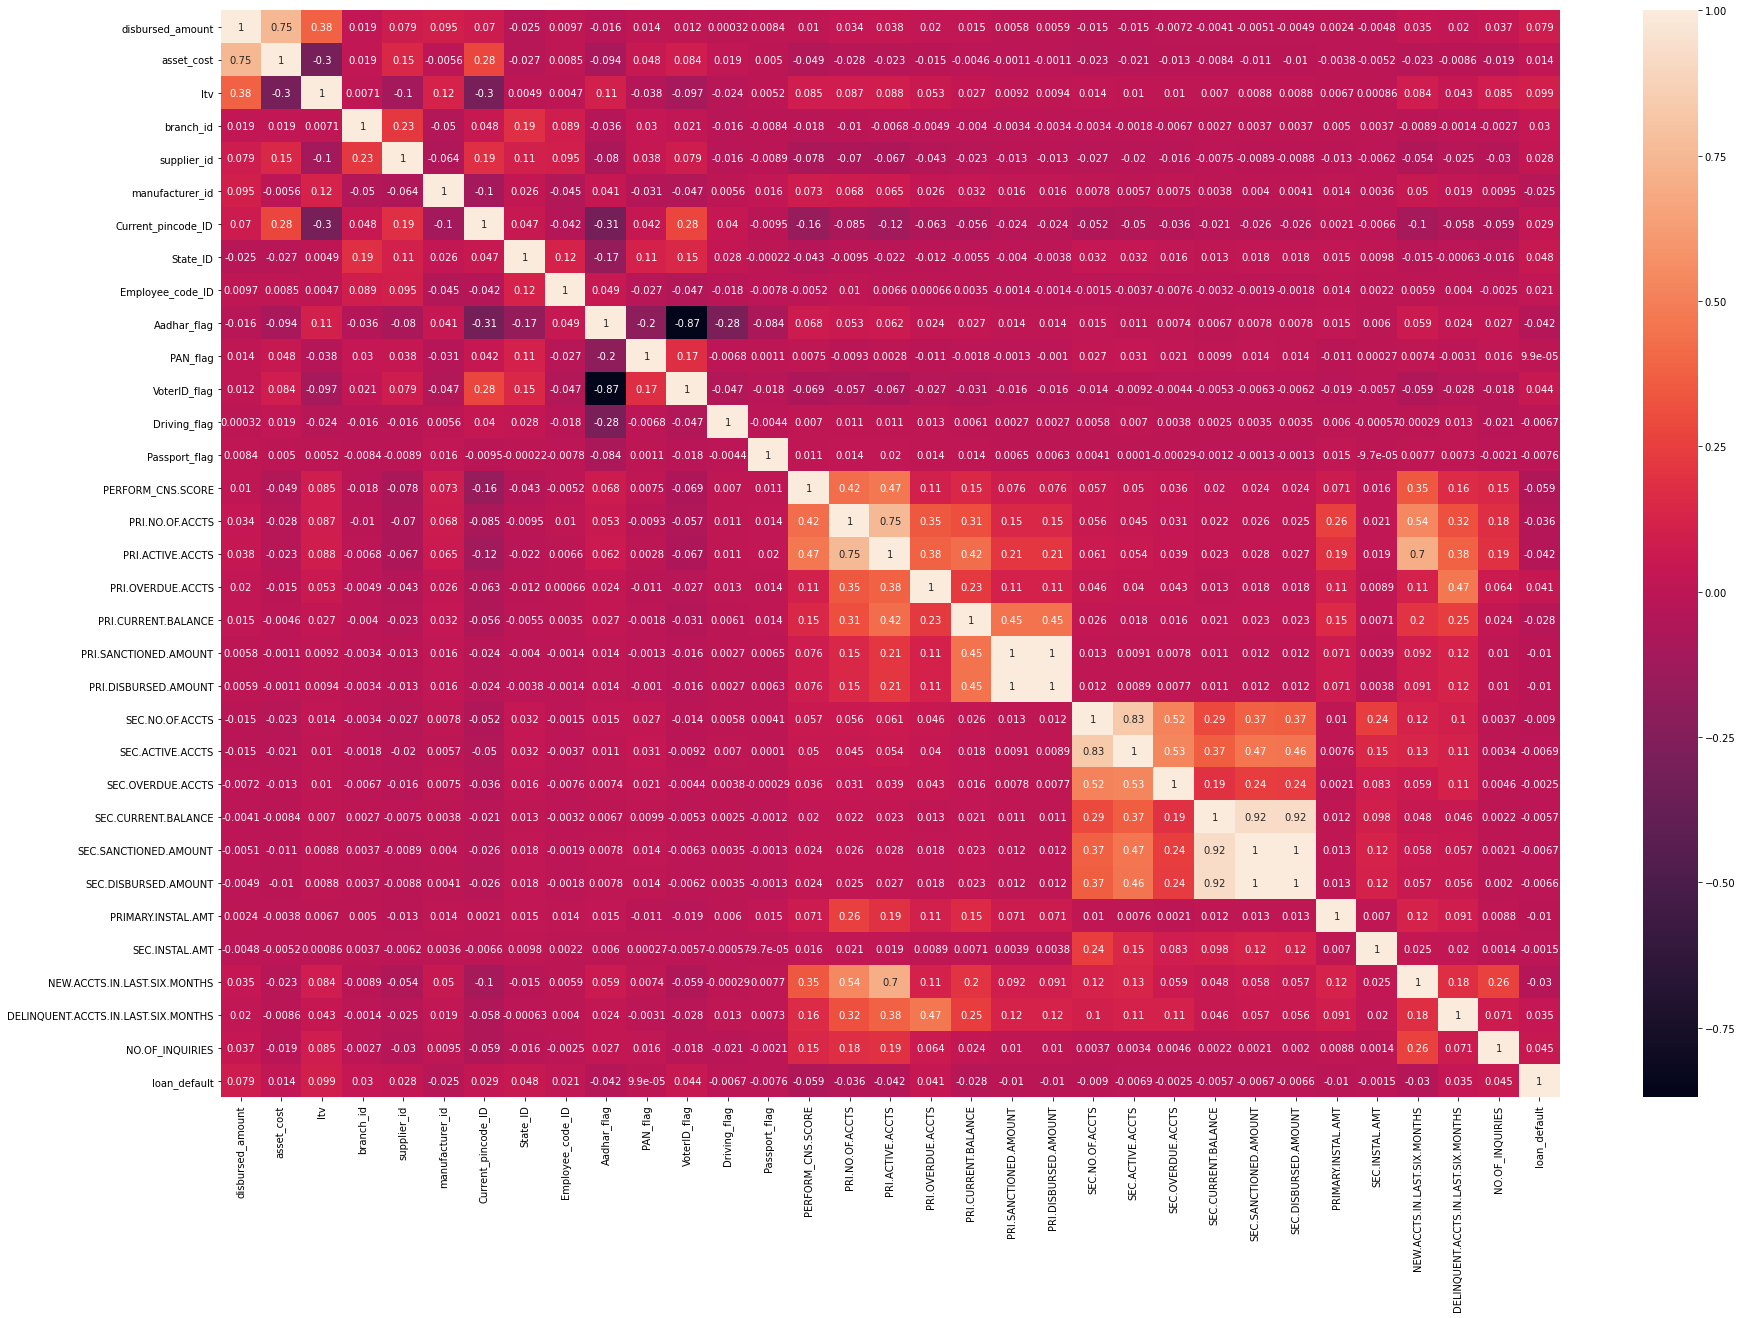

In [8]:
# Снова посмотрим на корреляцию признаков
corr = train.corr()
plt.figure(figsize=(30, 20))

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True)

In [9]:
corr['loan_default']

disbursed_amount                       0.078781
asset_cost                             0.014328
ltv                                    0.098746
branch_id                              0.029897
supplier_id                            0.028051
manufacturer_id                       -0.024635
Current_pincode_ID                     0.028513
State_ID                               0.048253
Employee_code_ID                       0.020878
Aadhar_flag                           -0.041758
PAN_flag                               0.000099
VoterID_flag                           0.043808
Driving_flag                          -0.006672
Passport_flag                         -0.007571
PERFORM_CNS.SCORE                     -0.058597
PRI.NO.OF.ACCTS                       -0.035893
PRI.ACTIVE.ACCTS                      -0.041833
PRI.OVERDUE.ACCTS                      0.041030
PRI.CURRENT.BALANCE                   -0.027616
PRI.SANCTIONED.AMOUNT                 -0.010347
PRI.DISBURSED.AMOUNT                  -0

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209883 entries, 0 to 209882
Data columns (total 39 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   disbursed_amount                     209883 non-null  int64  
 1   asset_cost                           209883 non-null  int64  
 2   ltv                                  209883 non-null  float64
 3   branch_id                            209883 non-null  int64  
 4   supplier_id                          209883 non-null  int64  
 5   manufacturer_id                      209883 non-null  int64  
 6   Current_pincode_ID                   209883 non-null  int64  
 7   Date.of.Birth                        209883 non-null  object 
 8   Employment.Type                      203019 non-null  object 
 9   DisbursalDate                        209883 non-null  object 
 10  State_ID                             209883 non-null  int64  
 11  Employee_code

In [11]:
train.head()

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


Думаю стоит убрать все признаки, которые просто обозначают ID

In [12]:
train_df_with_no_ids = train.drop(['branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'State_ID', 'Employee_code_ID'], axis=1)
train_df_with_no_ids.head()

,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,DisbursalDate,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,50578,58400,89.55,01-01-84,Salaried,03-08-18,1,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,47145,65550,73.23,31-07-85,Self employed,26-09-18,1,0,0,0,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,53278,61360,89.63,24-08-85,Self employed,01-08-18,1,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,57513,66113,88.48,30-12-93,Self employed,26-10-18,1,0,0,0,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,52378,60300,88.39,09-12-77,Self employed,26-09-18,1,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [13]:
import datetime
def from_dob_to_age(born):
    today = datetime.date.today()
    return today.year - born.year - ((today.month, today.day) < (born.month, born.day))

In [14]:
train_df_with_no_ids["Age"] = pd.to_datetime(train_df_with_no_ids['Date.of.Birth'])
train_df_with_no_ids.head(3)

,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,DisbursalDate,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,...,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Age
0,50578,58400,89.55,01-01-84,Salaried,03-08-18,1,0,0,0,...,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,1984-01-01
1,47145,65550,73.23,31-07-85,Self employed,26-09-18,1,0,0,0,...,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1,1985-07-31
2,53278,61360,89.63,24-08-85,Self employed,01-08-18,1,0,0,0,...,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,1985-08-24


In [15]:
train_df_with_no_ids["Age"] = train_df_with_no_ids["Age"].apply(lambda x: from_dob_to_age(x))
train_df_with_no_ids.head(3)

,disbursed_amount,asset_cost,ltv,Date.of.Birth,Employment.Type,DisbursalDate,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,...,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Age
0,50578,58400,89.55,01-01-84,Salaried,03-08-18,1,0,0,0,...,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,37
1,47145,65550,73.23,31-07-85,Self employed,26-09-18,1,0,0,0,...,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1,35
2,53278,61360,89.63,24-08-85,Self employed,01-08-18,1,0,0,0,...,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,35


In [16]:
train_df_with_no_ids = train_df_with_no_ids.drop(['Date.of.Birth'], axis=1)
train_df_with_no_ids.head(3)

,disbursed_amount,asset_cost,ltv,Employment.Type,DisbursalDate,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,...,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default,Age
0,50578,58400,89.55,Salaried,03-08-18,1,0,0,0,0,...,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,37
1,47145,65550,73.23,Self employed,26-09-18,1,0,0,0,0,...,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1,35
2,53278,61360,89.63,Self employed,01-08-18,1,0,0,0,0,...,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0,35


In [17]:
df_with_dummies = pd.get_dummies(train_df_with_no_ids, columns=['Employment.Type', 'PERFORM_CNS.SCORE.DESCRIPTION'])
df_with_dummies.head(3)

,disbursed_amount,asset_cost,ltv,DisbursalDate,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,...,PERFORM_CNS.SCORE.DESCRIPTION_K-High Risk,PERFORM_CNS.SCORE.DESCRIPTION_L-Very High Risk,PERFORM_CNS.SCORE.DESCRIPTION_M-Very High Risk,PERFORM_CNS.SCORE.DESCRIPTION_No Bureau History Available,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: More than 50 active Accounts found,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: No Activity seen on the customer (Inactive),PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: No Updates available in last 36 months,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Not Enough Info available on the customer,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Only a Guarantor,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Sufficient History Not Available
0,50578,58400,89.55,03-08-18,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,47145,65550,73.23,26-09-18,1,0,0,0,0,598,...,0,0,0,0,0,0,0,0,0,0
2,53278,61360,89.63,01-08-18,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


<AxesSubplot:>

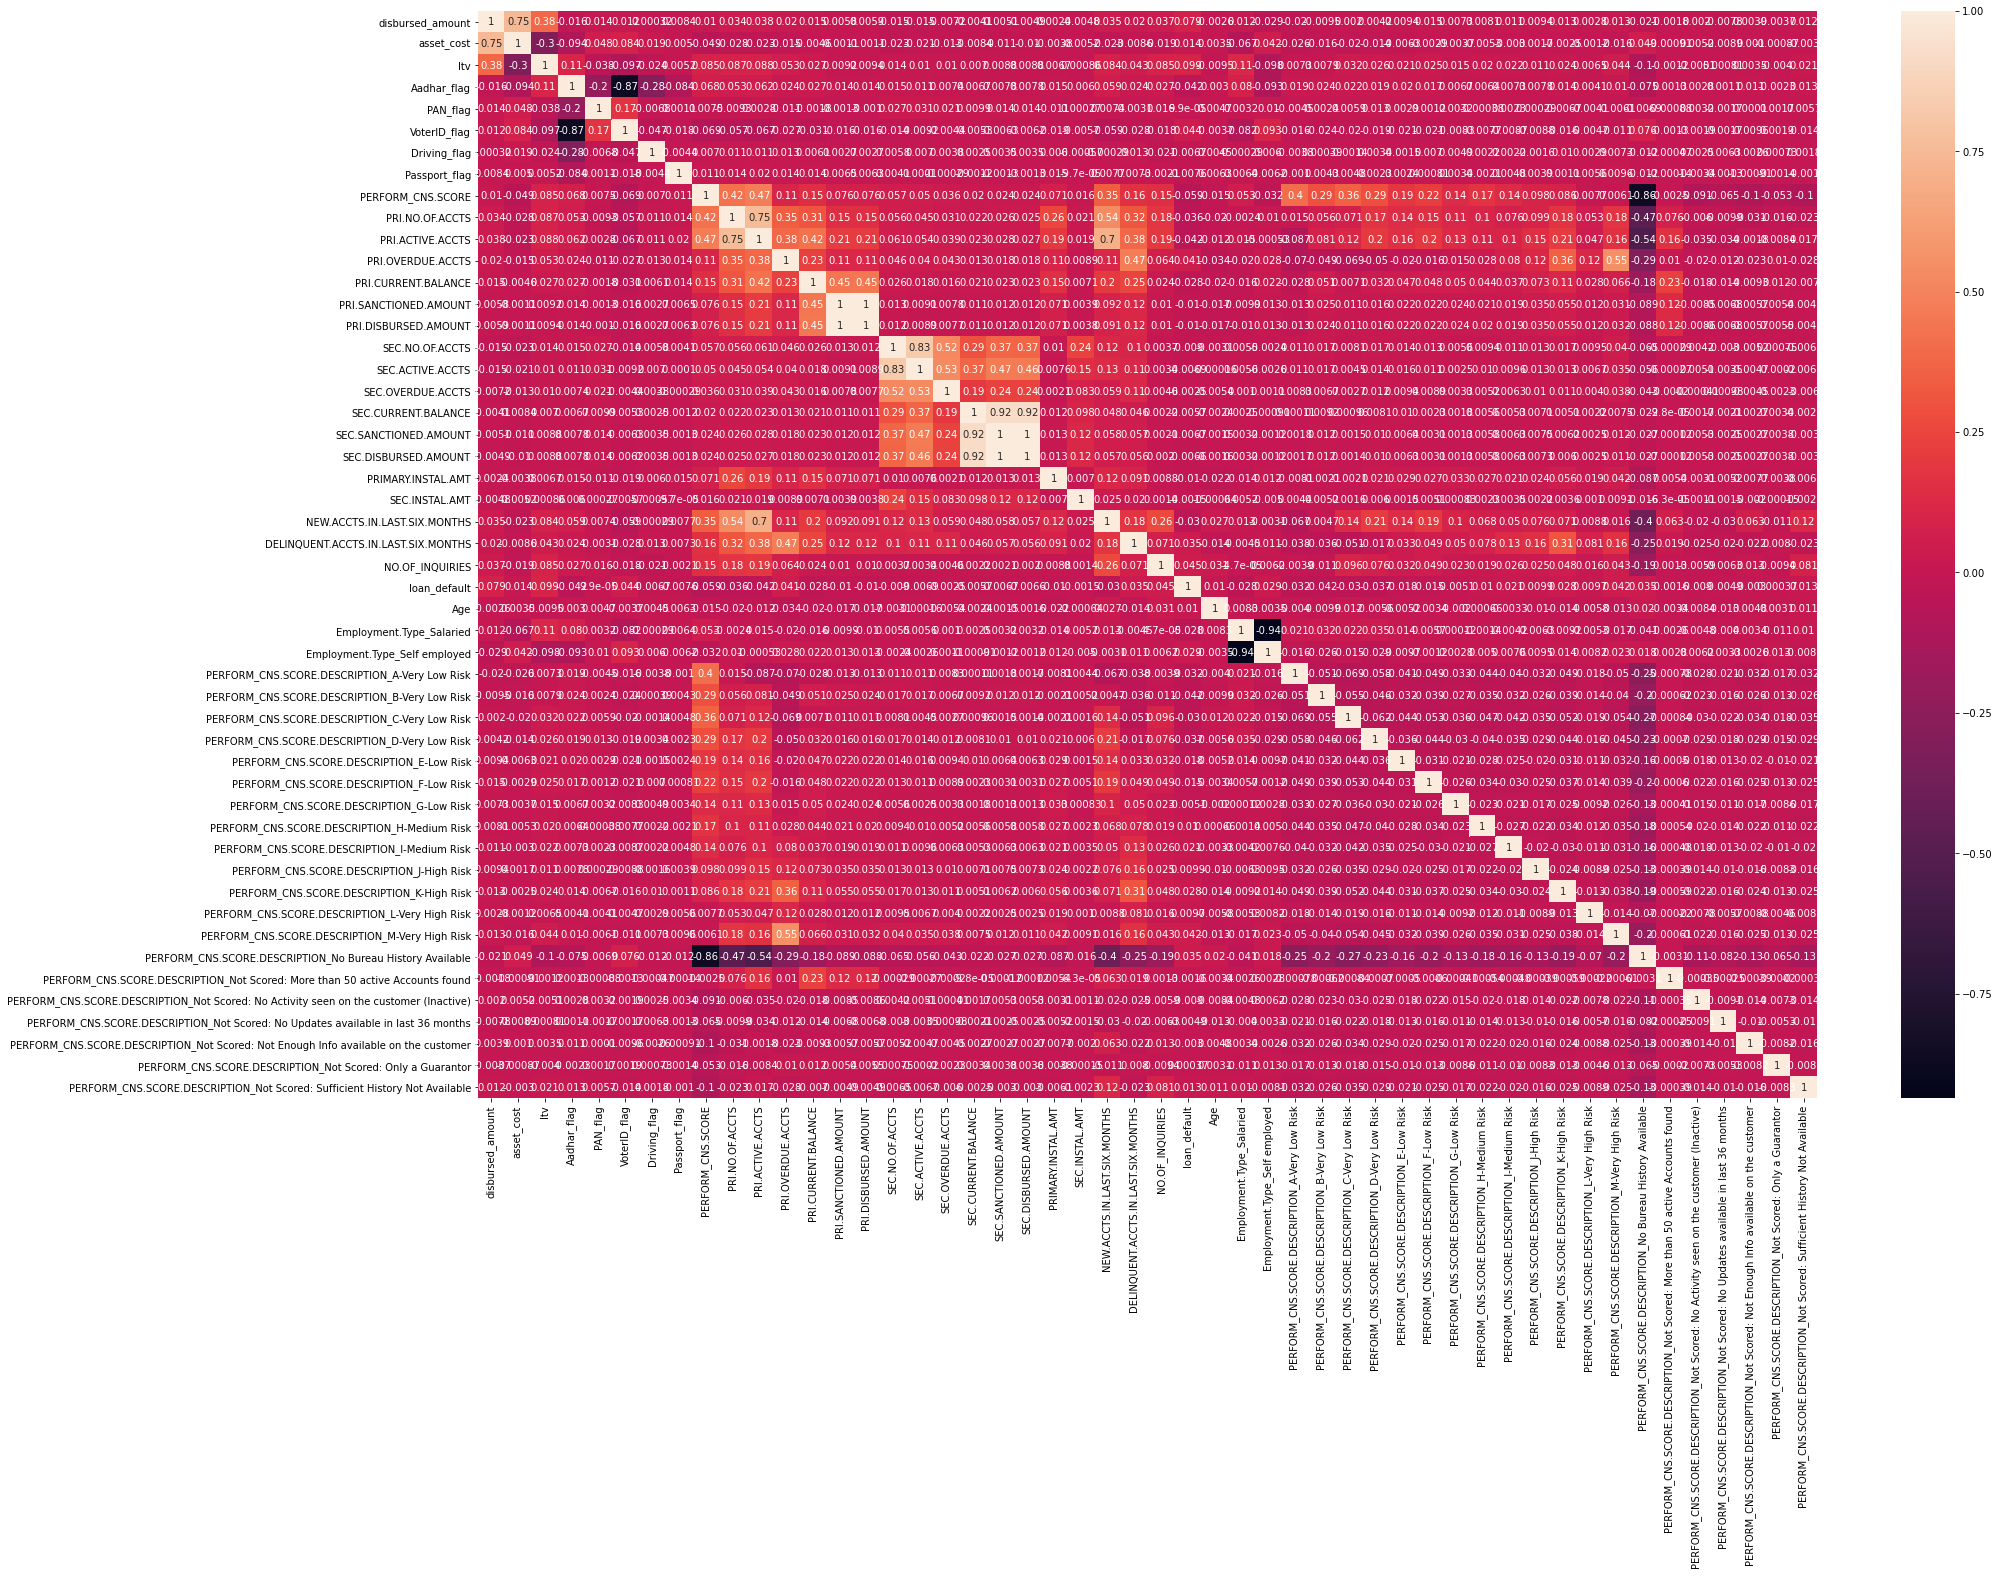

In [18]:
# Снова посмотрим на корреляцию признаков
corr = df_with_dummies.corr()
plt.figure(figsize=(30, 20))

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True)

In [19]:
df_with_dummies.columns

Index(['disbursed_amount', 'asset_cost', 'ltv', 'DisbursalDate', 'Aadhar_flag',
       'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag',
       'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES',
       'loan_default', 'Age', 'Employment.Type_Salaried',
       'Employment.Type_Self employed',
       'PERFORM_CNS.SCORE.DESCRIPTION_A-Very Low Risk',
       'PERFORM_CNS.SCORE.DESCRIPTION_B-Very Low Risk',
       'PERFORM_CNS.SCORE.DESCRIPTION_C-Very Low Risk',
       'PERFORM_CNS.SCORE.DESCRIPTION_D-Very Low Risk',
       'PERFORM_CNS.S

Следующие признаки достаточно сильно коррелируют между собой, думаю стоит убрать один из них:  

(asset_cost, disbursed_amount),  
(Aadhar_flag, VoterID_flag),  
(PRI.NO.OF.ACCTS, PRI.ACTIVE.ACCTS),
(PRI.ACTIVE.ACCTS, NEW.ACCTS.IN.LAST.SIX.MONTHS) 
(PRI.DISBURSED.AMOUNT, PRI.SANCTIONED.AMOUNT),  
(SEC.ACTIVE.ACCTS, SEC.NO.OF.ACCTS),  
(SEC.CURRENT.BALANCE, SEC.SANCTIONED.AMOUNT),  
(SEC.CURRENT.BALANCE, SEC.DISBURSED.AMOUNT),  
(SEC.SANCTIONED.AMOUNT, SEC.DISBURSED.AMOUNT),  
(Employment.Type_Self employed, Employment.Type_Salaried)
(PERFORM_CNS.SCORE.DESCRIPTION_No Bureau History Available, PERFORM_CNS.SCORE)

Признак DisbursalDate также показался мне бесполезным

In [20]:
df_with_dummies = df_with_dummies.drop(['DisbursalDate', 'asset_cost', 'VoterID_flag', 'PRI.NO.OF.ACCTS', 'PRI.DISBURSED.AMOUNT', 
                                       'SEC.ACTIVE.ACCTS', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'Employment.Type_Self employed',
                                       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'PERFORM_CNS.SCORE.DESCRIPTION_No Bureau History Available'], axis=1)

<AxesSubplot:>

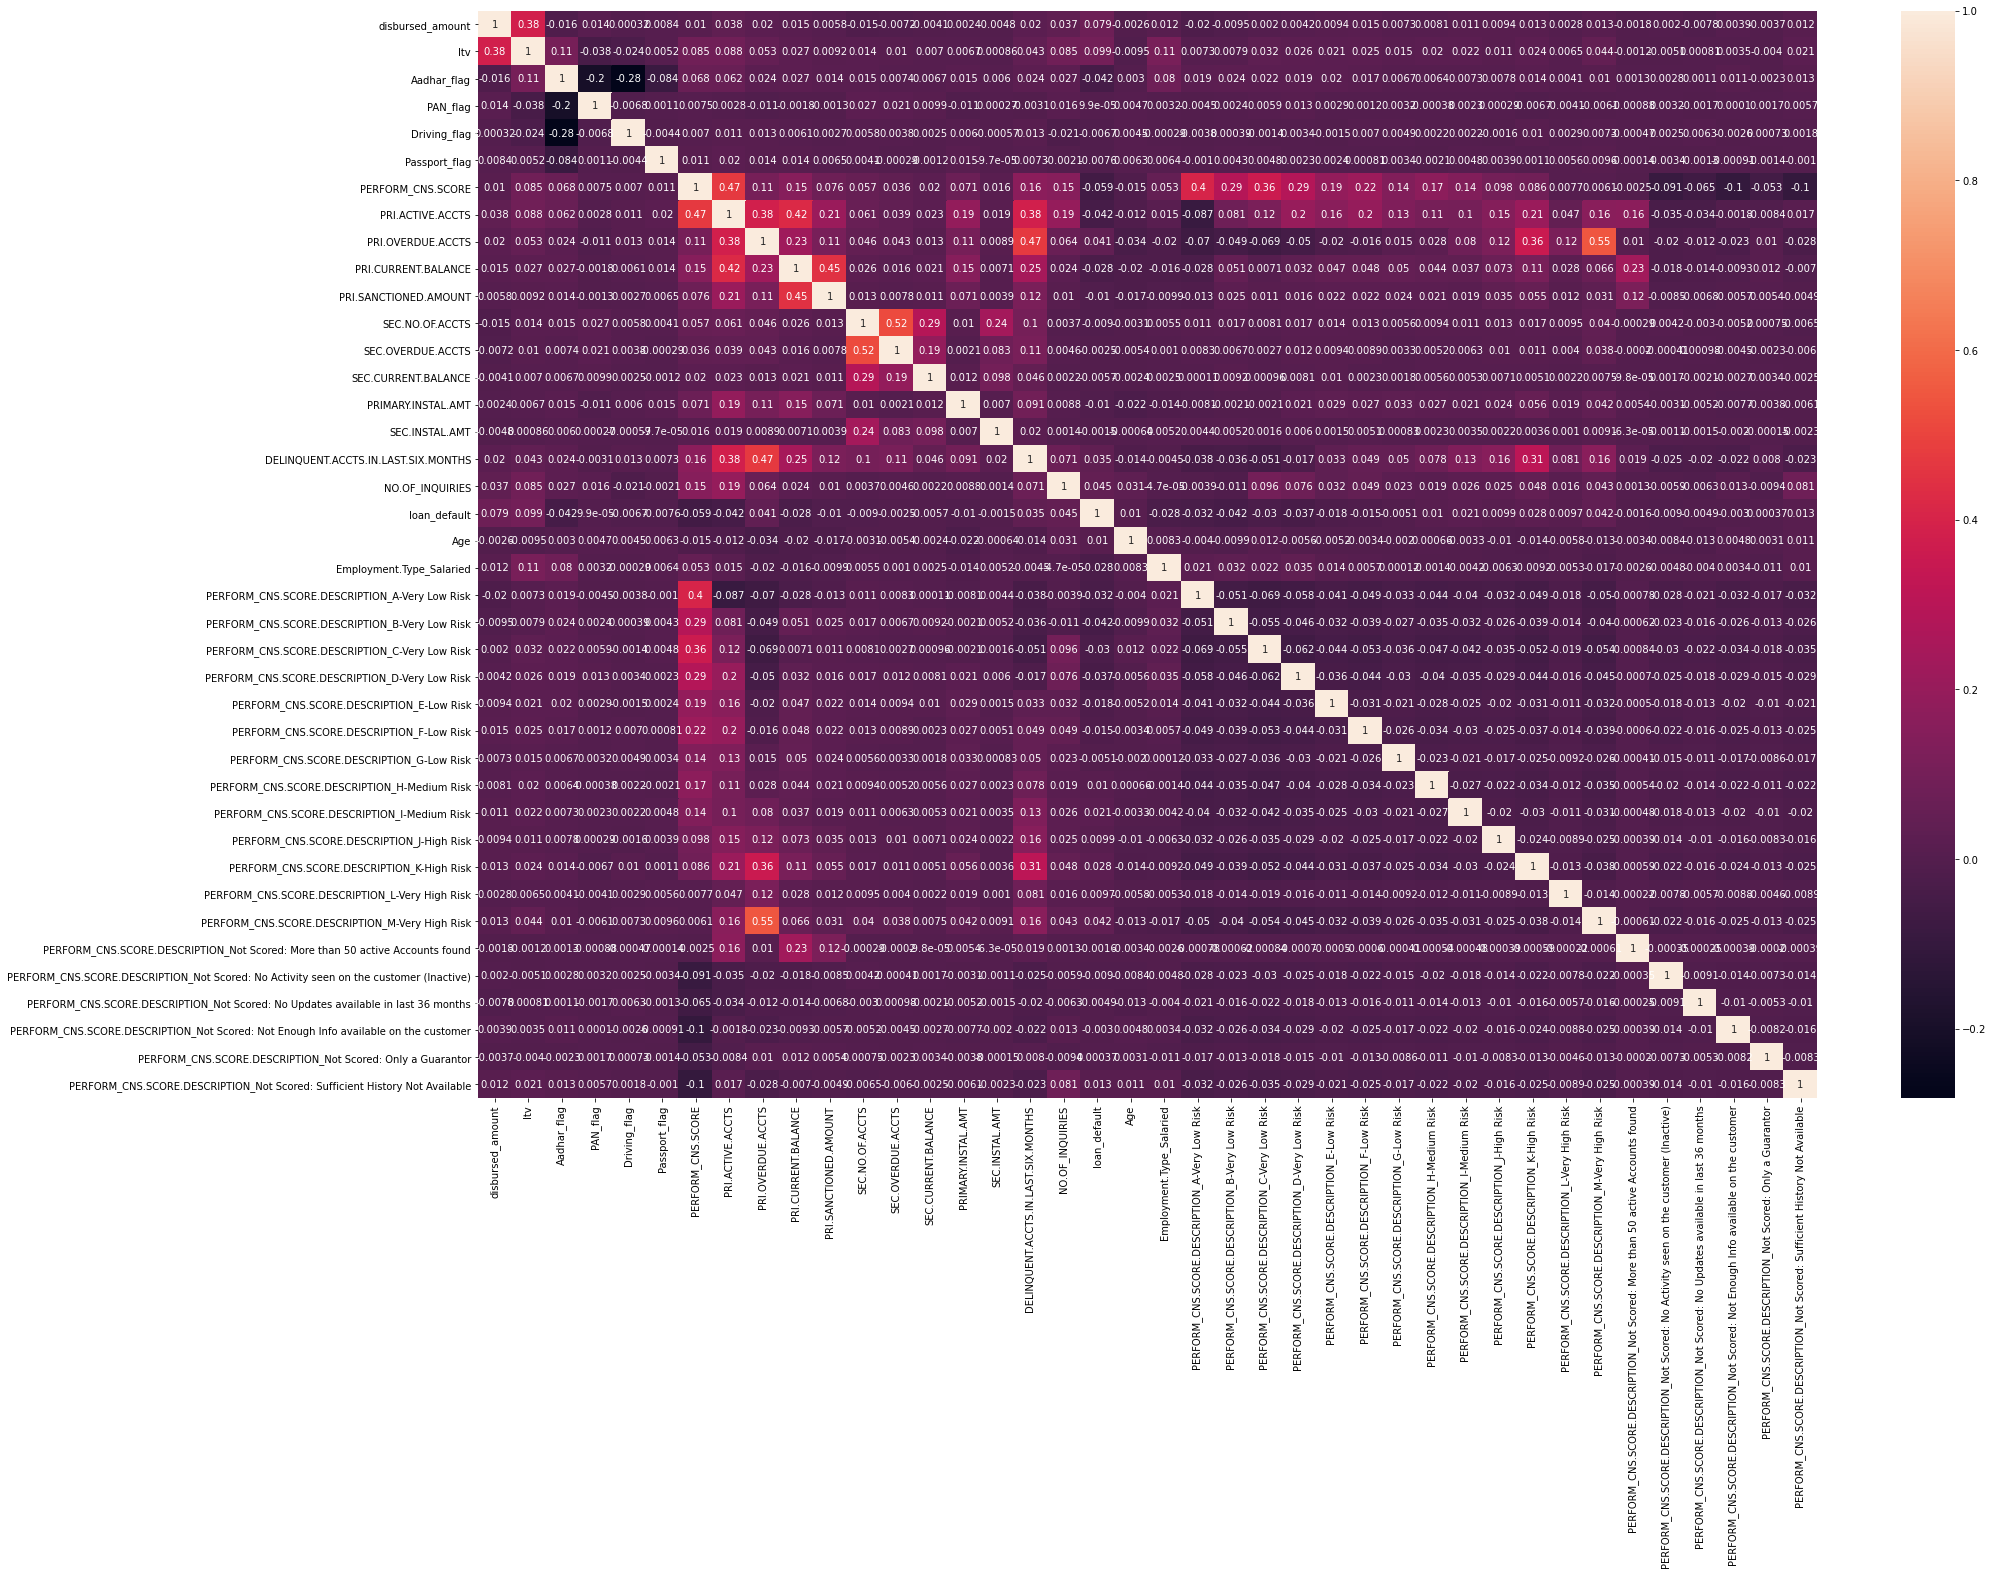

In [21]:
# Снова посмотрим на корреляцию признаков
corr = df_with_dummies.corr()
plt.figure(figsize=(30, 20))

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True)

In [22]:
df_with_dummies.head()

,disbursed_amount,ltv,Aadhar_flag,PAN_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,...,PERFORM_CNS.SCORE.DESCRIPTION_J-High Risk,PERFORM_CNS.SCORE.DESCRIPTION_K-High Risk,PERFORM_CNS.SCORE.DESCRIPTION_L-Very High Risk,PERFORM_CNS.SCORE.DESCRIPTION_M-Very High Risk,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: More than 50 active Accounts found,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: No Activity seen on the customer (Inactive),PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: No Updates available in last 36 months,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Not Enough Info available on the customer,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Only a Guarantor,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Sufficient History Not Available
0,50578,89.55,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,47145,73.23,1,0,0,0,598,1,1,27600,...,0,0,0,0,0,0,0,0,0,0
2,53278,89.63,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,57513,88.48,1,0,0,0,305,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,52378,88.39,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


AVERAGE.ACCT.AGE и CREDIT.HISTORY.LENGTH тоже стоит перевести в какое-то число

In [23]:
def get_total_from_yrs_mon(str):
    import re
    arr = re.findall(r'\d+', str)
    return int(arr[0])*365 + int(arr[1])*30

In [24]:
df_with_dummies["AVERAGE.ACCT.AGE"] = df_with_dummies["AVERAGE.ACCT.AGE"].apply(lambda x: get_total_from_yrs_mon(x))
df_with_dummies["CREDIT.HISTORY.LENGTH"] = df_with_dummies["CREDIT.HISTORY.LENGTH"].apply(lambda x: get_total_from_yrs_mon(x))

In [25]:
df_with_dummies.head()

,disbursed_amount,ltv,Aadhar_flag,PAN_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,...,PERFORM_CNS.SCORE.DESCRIPTION_J-High Risk,PERFORM_CNS.SCORE.DESCRIPTION_K-High Risk,PERFORM_CNS.SCORE.DESCRIPTION_L-Very High Risk,PERFORM_CNS.SCORE.DESCRIPTION_M-Very High Risk,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: More than 50 active Accounts found,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: No Activity seen on the customer (Inactive),PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: No Updates available in last 36 months,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Not Enough Info available on the customer,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Only a Guarantor,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Sufficient History Not Available
0,50578,89.55,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,47145,73.23,1,0,0,0,598,1,1,27600,...,0,0,0,0,0,0,0,0,0,0
2,53278,89.63,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,57513,88.48,1,0,0,0,305,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,52378,88.39,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
corr['loan_default']

disbursed_amount                                                                         0.078781
ltv                                                                                      0.098746
Aadhar_flag                                                                             -0.041758
PAN_flag                                                                                 0.000099
Driving_flag                                                                            -0.006672
Passport_flag                                                                           -0.007571
PERFORM_CNS.SCORE                                                                       -0.058597
PRI.ACTIVE.ACCTS                                                                        -0.041833
PRI.OVERDUE.ACCTS                                                                        0.041030
PRI.CURRENT.BALANCE                                                                     -0.027616
PRI.SANCTIONED.AMOUN

In [27]:
# Получим наконец наши признаки и целевую переменную для тренировочной выборки
X_train = df_with_dummies.drop(['loan_default'], axis=1)
y_train = df_with_dummies.loan_default

In [29]:
X_train.head()

,disbursed_amount,ltv,Aadhar_flag,PAN_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,...,PERFORM_CNS.SCORE.DESCRIPTION_J-High Risk,PERFORM_CNS.SCORE.DESCRIPTION_K-High Risk,PERFORM_CNS.SCORE.DESCRIPTION_L-Very High Risk,PERFORM_CNS.SCORE.DESCRIPTION_M-Very High Risk,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: More than 50 active Accounts found,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: No Activity seen on the customer (Inactive),PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: No Updates available in last 36 months,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Not Enough Info available on the customer,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Only a Guarantor,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Sufficient History Not Available
0,50578,89.55,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,47145,73.23,1,0,0,0,598,1,1,27600,...,0,0,0,0,0,0,0,0,0,0
2,53278,89.63,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,57513,88.48,1,0,0,0,305,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,52378,88.39,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:
# Подкачиваем тестовую выборку
test = pd.read_csv(DATA_DIR + 'default_test.csv')
test.head()

,id,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,1,52603,61300,86.95,67,22807,45,1492,01-06-68,Salaried,...,0,0,0,2608,0,0,0,1yrs 7mon,1yrs 7mon,0
1,2,49478,57010,89.46,67,22807,45,1497,16-08-84,Salaried,...,0,0,0,23309,0,1,0,1yrs 0mon,2yrs 1mon,4
2,3,53503,62100,87.28,67,22807,45,1498,27-02-83,Self employed,...,0,0,0,4982,0,1,0,1yrs 10mon,4yrs 7mon,0
3,4,70017,86760,82.99,67,22807,45,1479,10-08-88,Self employed,...,0,0,0,0,0,0,0,1yrs 9mon,1yrs 9mon,0
4,5,50678,58300,89.88,67,22807,45,1474,01-06-77,Self employed,...,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0


In [33]:
test.columns

Index(['id', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id',
       'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth',
       'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID',
       'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE',
       'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS',
       'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT',
       'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS',
       'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT',
       'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT',
       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS',
       'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES'],
      dtype='object')

In [34]:
# В одной ячейке отсеим все данные, как это делали для тренировочной выборки
test_df = test.drop(['branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID',
                                   'State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag'], axis=1)
test_df["Age"] = pd.to_datetime(test_df['Date.of.Birth'])
test_df["Age"] = test_df["Age"].apply(lambda x: from_dob_to_age(x))
test_df = test_df.drop(['Date.of.Birth'], axis=1)
test_df_with_dummies = pd.get_dummies(test_df, columns=['Employment.Type', 'PERFORM_CNS.SCORE.DESCRIPTION'])
test_df_with_dummies = test_df_with_dummies.drop(['DisbursalDate', 'asset_cost', 'VoterID_flag', 'PRI.NO.OF.ACCTS', 'PRI.DISBURSED.AMOUNT', 
                                       'SEC.ACTIVE.ACCTS', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'Employment.Type_Self employed',
                                       'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'PERFORM_CNS.SCORE.DESCRIPTION_No Bureau History Available'], axis=1)
test_df_with_dummies["AVERAGE.ACCT.AGE"] = test_df_with_dummies["AVERAGE.ACCT.AGE"].apply(lambda x: get_total_from_yrs_mon(x))
test_df_with_dummies["CREDIT.HISTORY.LENGTH"] = test_df_with_dummies["CREDIT.HISTORY.LENGTH"].apply(lambda x: get_total_from_yrs_mon(x))
test_df_with_dummies.head()

,id,disbursed_amount,ltv,Aadhar_flag,PAN_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,...,PERFORM_CNS.SCORE.DESCRIPTION_J-High Risk,PERFORM_CNS.SCORE.DESCRIPTION_K-High Risk,PERFORM_CNS.SCORE.DESCRIPTION_L-Very High Risk,PERFORM_CNS.SCORE.DESCRIPTION_M-Very High Risk,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: More than 50 active Accounts found,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: No Activity seen on the customer (Inactive),PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: No Updates available in last 36 months,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Not Enough Info available on the customer,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Only a Guarantor,PERFORM_CNS.SCORE.DESCRIPTION_Not Scored: Sufficient History Not Available
0,1,52603,86.95,0,0,0,0,818,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,49478,89.46,1,0,0,0,738,5,0,...,0,0,0,0,0,0,0,0,0,0
2,3,53503,87.28,1,0,0,0,688,8,0,...,0,0,0,0,0,0,0,0,0,0
3,4,70017,82.99,0,0,0,0,585,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,50678,89.88,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209883 entries, 0 to 209882
Data columns (total 41 columns):
 #   Column                                                                                 Non-Null Count   Dtype  
---  ------                                                                                 --------------   -----  
 0   disbursed_amount                                                                       209883 non-null  int64  
 1   ltv                                                                                    209883 non-null  float64
 2   Aadhar_flag                                                                            209883 non-null  int64  
 3   PAN_flag                                                                               209883 non-null  int64  
 4   Driving_flag                                                                           209883 non-null  int64  
 5   Passport_flag                                                    

In [39]:
test_df_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23271 entries, 0 to 23270
Data columns (total 42 columns):
 #   Column                                                                                 Non-Null Count  Dtype  
---  ------                                                                                 --------------  -----  
 0   id                                                                                     23271 non-null  int64  
 1   disbursed_amount                                                                       23271 non-null  int64  
 2   ltv                                                                                    23271 non-null  float64
 3   Aadhar_flag                                                                            23271 non-null  int64  
 4   PAN_flag                                                                               23271 non-null  int64  
 5   Driving_flag                                                              

In [41]:
X_test = test_df_with_dummies.drop(['id'], axis=1)

In [44]:
scaler = StandardScaler()
cover_X_train = scaler.fit_transform(X_train)
cover_X_test = scaler.transform(X_test)

In [50]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)

stacked_features_train, stacked_features_test = generate_meta_features([
    KNeighborsClassifier(n_jobs=-1),
    ExtraTreesClassifier(n_estimators=300, n_jobs=-1),
], cover_X_train, cover_X_test, y_train, cv)

100%|██████████| 2/2 [45:24<00:00, 1362.38s/it]


In [51]:
clf = LogisticRegression(penalty='none', solver='lbfgs')
clf.fit(stacked_features_train, y_train)
submission = clf.predict(stacked_features_test)

In [52]:
sample_submission = pd.read_csv(DATA_DIR + 'default_sample_submission.csv')
sample_submission.head()

,id,loan_default
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1


In [53]:
sample_submission['loan_default'] = submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,id,loan_default
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0
